In [2]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow import keras 
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, \
   Conv2DTranspose, MaxPooling2D, Dropout, \
BatchNormalization, Activation, concatenate
from tensorflow.keras.optimizers import Adam

In [3]:
DATA_DIR = ' ./data/CamVid'
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [4]:
# class for data loading and preprocessing 
class CamVidDataset: 
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args: 
      images_dir (str): path to images folder 
      masks_dir (str): path to segmentation masks folder 
      class_values (list): values of classes to extract from segmentation mask 
      preprocessing (albumentations.Compose): data preprocessing 
        (e.g. normalization, shape manipulation, etc.)
    """
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']
    def __init__(
        self, 
        images_dir, 
        masks_dir, 
        classes=CLASSES, 
        preprocessing=None, 
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks 
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.preprocessing = preprocessing 

    def __getitem__(self, i):
        # read data 
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary 
        if mask.shape[-1] != 1:
          background = 1 - mask.sum(axis=-1, keepdims=True)
          mask = np.concatenate((mask, background), axis=-1)

        return image, mask
    def __len__(self):
        return len(self.ids)

367
Image shape: (360, 480, 3)
Mask shape: (360, 480, 7)


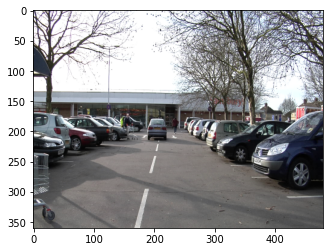

In [5]:
x_train_dir = "./data/CamVid/train"
y_train_dir = "./data/CamVid/trainannot"

x_valid_dir = "./data/CamVid/val"
y_valid_dir = "./data/CamVid/valannot"

x_test_dir = "./data/CamVid/test"
y_test_dir = "./data/CamVid/testannot"

CLASSES = ['car', 'pedestrian', 'sky', 'tree', 'road', 'building']

dataset = CamVidDataset(x_train_dir, y_train_dir, classes=CLASSES)

print(len(dataset))
image, mask = dataset[5]
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')
plt.imshow(image)
plt.show()



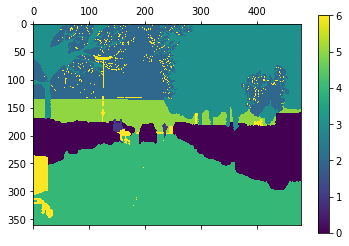

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

color_ax = ax.matshow(np.argmax(mask, axis =- 1))
fig.colorbar(color_ax)
plt.show()

# this will tell us what number and hence color, 
# corresponsds to what class
for i, the_class in enumerate(CLASSES):
        print(i, the_class)
        

In [7]:
def crop_image(height, width, image):
    cropped_image = image[:height, :width, :]
    return cropped_image

In [8]:
class CamVidDataGenerator(keras.utils.Sequence):
    """Load batches of data from CamVidDataset 
    refer to this article on how to create a custom data generator:
    
    Args: 
        dataset: instance of CamVidDataset class fro image loading and preprocessing. 
        batch_size: Number of images in each batch. 
        dim: Tuple of image height and width 
        n_channesl: Num of image channels 
        n_classes: Num of label classes 
        shuffle: Boolean, if 'True' shuffle image indexes each epoch. 
    """
    
    
    def __init__(self, dataset, batch_size = 32, dim = (352, 480), n_channels = 3, n_classes = 7, shuffle = True):
        self.dataset = dataset 
        self.batch_size = batch_size 
        self.dim = dim
        self.n_channels = n_channels 
        self.n_classes = n_classes 
        self.shuffle = shuffle 
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()
    def __getitem__(self, index):
        # Initialization 
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        # Generate indexes of the batch 
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        
        # Generate data 
        for i, ID in enumerate(indexes):
            image, mask = dataset[ID]
            X[i,] = crop_image(*self.dim, image)
            y[i] = crop_image(*self.dim, mask)
        return X, y
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)
 # Dataset for train images 
train_dataset = CamVidDataset(
        x_train_dir,
        y_train_dir, 
        classes=CLASSES,
    )
# Dataset for validation images
valid_dataset = CamVidDataset(
        x_valid_dir, 
        y_valid_dir, 
        classes=CLASSES,
    )
    
    # Parameters 
BATCH_SIZE = 4 
params = {'batch_size': BATCH_SIZE,
                'dim': (352, 480), 
                 'n_channels': 3,
                 'n_classes': len(CLASSES)+1,
                 'shuffle': True}
# Generators
training_generator = CamVidDataGenerator(train_dataset, **params)
validation_generator = CamVidDataGenerator(valid_dataset, **params)


In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = input_tensor
    for i in range(2):
        x = Conv2D(filters = n_filters, kernel_size = (kernel_size), kernel_initializer = "he_normal", padding = "same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x
def get_unet(input_img, n_filters = 16, dropout = 0.5, batchnorm = True):
    # contracting path 
    x = input_img 
    convs = []
    for i in range(4):
        x = conv2d_block(x, n_filters = n_filters*(2**i), kernel_size = 3, batchnorm=batchnorm)
        convs.append(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(dropout*(1, 0.5)[i == 0])(x)
    x = conv2d_block(x, n_filters=n_filters*(2**4), kernel_size=3, batchnorm=batchnorm)
    # expansive path 
    for i in range(3, -1, -1):
        x = Conv2DTranspose(n_filters*(2**1), (3, 3), strides=(2,2), padding='same')(x)
        x = concatenate([x,convs[i]])
        x = Dropout(dropout)(x)
        x = conv2d_block(x, n_filters=n_filters*(2**i), kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(n_filters, (1, 1), activation='softmax')(x)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [10]:
# Defining the input shape for out model to trainon 
# U-Net input height and width must be a factor of 16
INPUT_HEIGHT = 352
INPUT_WIDTH = 480
N_CHANNELS = 3
input_img = keras.Input((INPUT_HEIGHT, INPUT_WIDTH, N_CHANNELS), name = 'img')
# create model
model = get_unet(input_img, n_filters= len(CLASSES) + 1, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss = "binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 352, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 352, 480, 7)  196         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 352, 480, 7)  28          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 352, 480, 7)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
91/91 [==============================] - 20s 128ms/step - loss: 0.7190 - accuracy: 0.3462 - val_loss: 0.6716 - val_accuracy: 0.1594

Epoch 00001: val_accuracy improved from -inf to 0.15940, saving model to ./ckpt.hdf5
Epoch 2/100
91/91 [==============================] - 11s 123ms/step - loss: 0.5834 - accuracy: 0.2948 - val_loss: 0.6173 - val_accuracy: 0.3894

Epoch 00002: val_accuracy improved from 0.15940 to 0.38942, saving model to ./ckpt.hdf5
Epoch 3/100
91/91 [==============================] - 11s 123ms/step - loss: 0.4978 - accuracy: 0.6327 - val_loss: 0.4376 - val_accuracy: 0.6170

Epoch 00003: val_accuracy improved from 0.38942 to 0.61696, saving model to ./ckpt.hdf5
Epoch 4/100
91/91 [==============================] - 11s 123ms/step - loss: 0.4382 - accuracy: 0.6371 - val_loss: 0.4115 - val_accuracy: 0.5324

Epoch 00004: val_accuracy did not improve from 0.61696
Epoch 5/100
91/91 [==============================] - 11s 122ms/step - loss: 0.3784 - accuracy: 0.4760 - 

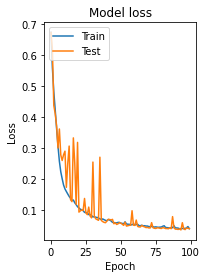

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
EPOCHS = 100
history = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=[ModelCheckpoint(filepath='./ckpt.hdf5', monitor='val_accuracy', save_best_only=True, verbose=1), EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
model.save_weights('your_weights.h5')
model.load_weights('your_weights.h5')

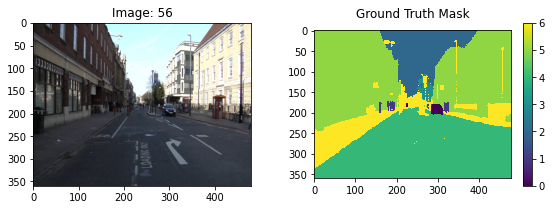

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


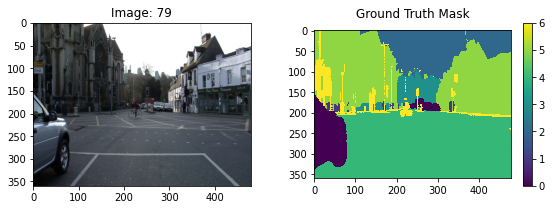

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


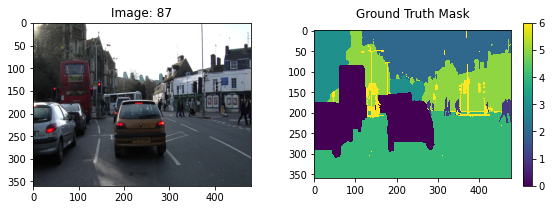

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


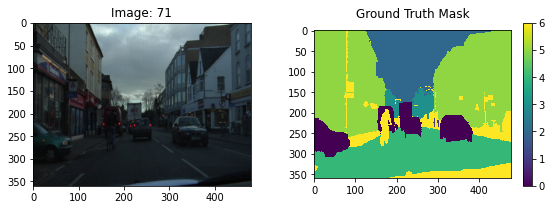

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


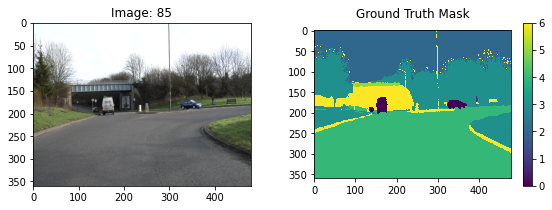

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


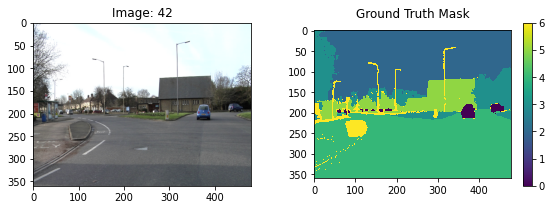

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


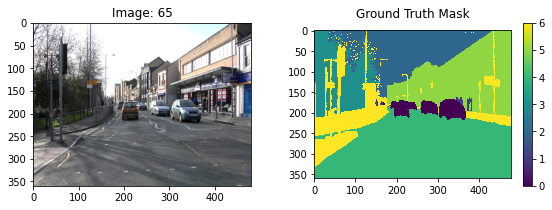

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


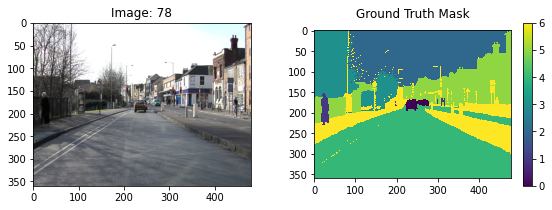

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


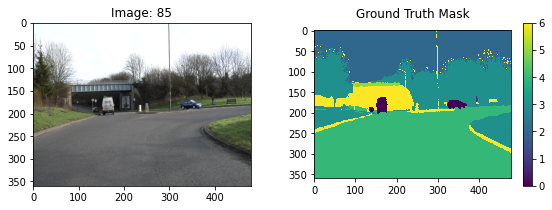

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


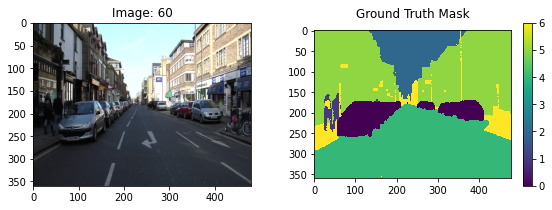

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


In [52]:
# Dataset for test images 
train_dataset = CamVidDataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES
)

# look at some random images 
ids = [56, 79, 87, 71, 85, 42, 65, 78, 85, 60 ]
for i in ids:
  image, gt_mask = train_dataset[i]

  cropped_image = crop_image(INPUT_HEIGHT, INPUT_WIDTH, image)
  image_array = np.expand_dims(cropped_image, axis=0).astype('float')
  pr_mask = model.predict(image_array)

  fig = plt.figure(figsize=(15, 3))
  ax = fig.add_subplot(131)
  ax.imshow(image)
  ax.set_title("Image: %d" %(i,))

  ax = fig.add_subplot(132)
  cropped_gt_mask = crop_image(INPUT_HEIGHT, INPUT_WIDTH, gt_mask)
  color_ax = ax.matshow(np.argmax(gt_mask, axis =-1))
  ax.set_title("Ground Truth Mask")
  ax.xaxis.tick_bottom()

  fig.colorbar(color_ax)
  plt.show()

  for i, the_class in enumerate(CLASSES):
    print(i, the_class)

In [21]:
params['shuffle'] = False 
params["batch_size"] = 1
test_generator = CamVidDataGenerator(
    test_dataset, **params)
model.evaluate(test_generator)


233/233 [==============================] - 6s 24ms/step - loss: 0.0414 - accuracy: 0.9433


[0.04140474274754524, 0.9432852268218994]

In [23]:
y_hat = model.predict(test_generator)
y_hat = np.argmax(y_hat, axis =-1 )
y_hat = y_hat.flatten()

y_real = np.array([e[1] for e in test_generator])
y_real = np.argmax(y_real, axis=-1)
y_real = y_real.flatten()

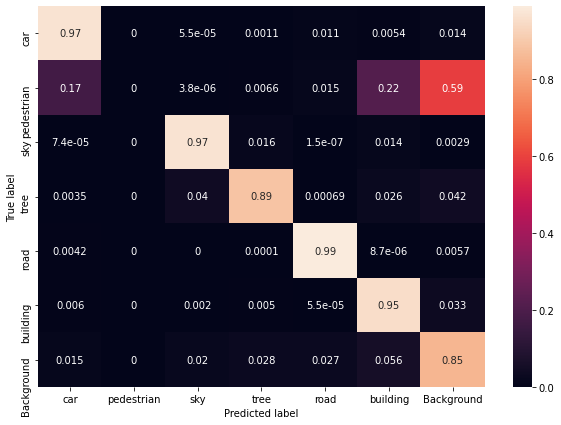

In [26]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sns
df_cm = pd.DataFrame(confusion_matrix(y_real, y_hat, normalize="true"), index = CLASSES + ["Background"], columns = CLASSES + ["Background"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

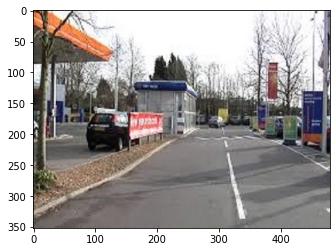

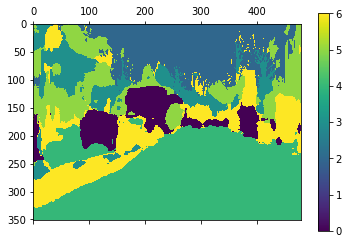

0 car
1 pedestrian
2 sky
3 tree
4 road
5 building


In [50]:
image = cv2.imread('dashcam8.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cropped_image = crop_image(INPUT_HEIGHT, INPUT_WIDTH, image)
image_array = np.expand_dims(cropped_image, axis=0).astype('float')
pr_mask = model.predict(image_array)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(cropped_image)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
color_ax = ax.matshow(np.argmax(pr_mask.squeeze(), axis=-1))
fig.colorbar(color_ax)
plt.show()

for i, the_class in enumerate(CLASSES):
  print(i, the_class)